In [1]:
import pandas as pd
import numpy as np
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification
import torch
from IPython.display import display
from nltk.tokenize import TweetTokenizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
class config:
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_name = "cardiffnlp/twitter-roberta-base-sentiment"
    epochs = 1
    batch_size = 16
    max_length=35

In [3]:
tweets_dataset = pd.read_csv("../input/emotion-detection-from-text/tweet_emotions.csv")
display(tweets_dataset)

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...
...,...,...,...
39995,1753918954,neutral,@JohnLloydTaylor
39996,1753919001,love,Happy Mothers Day All my love
39997,1753919005,love,Happy Mother's Day to all the mommies out ther...
39998,1753919043,happiness,@niariley WASSUP BEAUTIFUL!!! FOLLOW ME!! PEE...


In [4]:
unwanted_classes = ["empty", "enthusiasm", "surprise", "love", "fun", "boredom", "relief", "anger"]
for label in unwanted_classes:
    tweets_dataset = tweets_dataset[tweets_dataset["sentiment"] != label]

In [5]:
def ExpandLabelsToPretrained(label):
    if (label=="sadness") or (label=="hate") or (label=="worry"):
        return "negative"
    elif label == "neutral":
        return "neutral"
    else:
        return "positive"

In [6]:
tweets_dataset["sentiment"] = tweets_dataset["sentiment"].apply(ExpandLabelsToPretrained)

In [7]:
tokenizer = AutoTokenizer.from_pretrained(config.model_name)
label2num = {label : i for i, label in enumerate(tweets_dataset["sentiment"].unique())}
label2num

Downloading:   0%|          | 0.00/747 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

{'negative': 0, 'neutral': 1, 'positive': 2}

<AxesSubplot:>

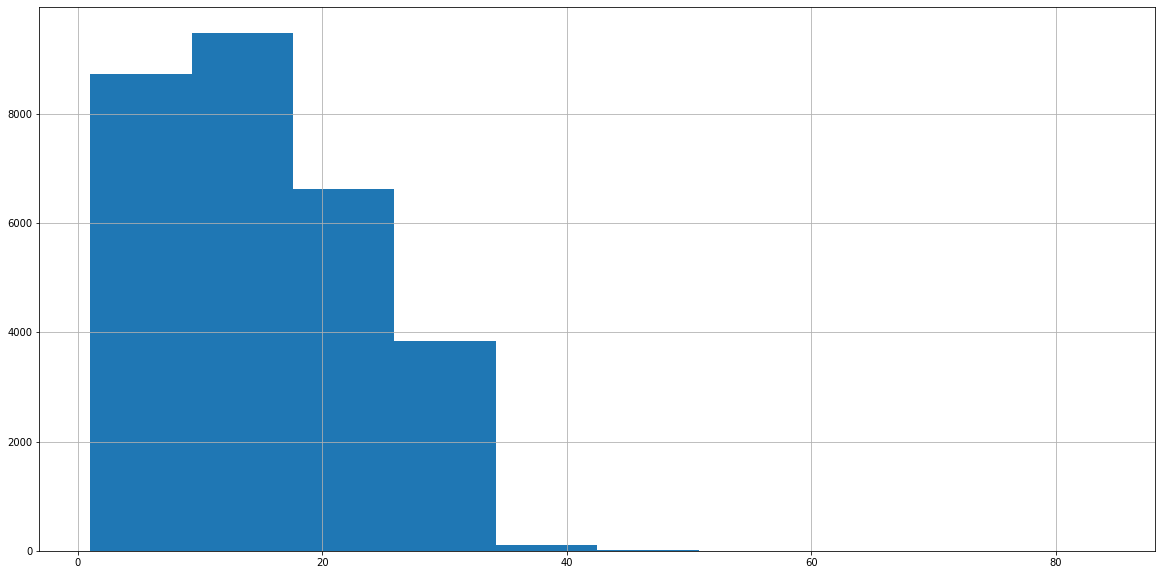

In [8]:
tweets_dataset["tokens"] = tweets_dataset["content"].apply(TweetTokenizer().tokenize)
tweets_dataset["word_count"] = tweets_dataset["tokens"].apply(len)
tweets_dataset["word_count"].hist(figsize=(20, 10))

<AxesSubplot:>

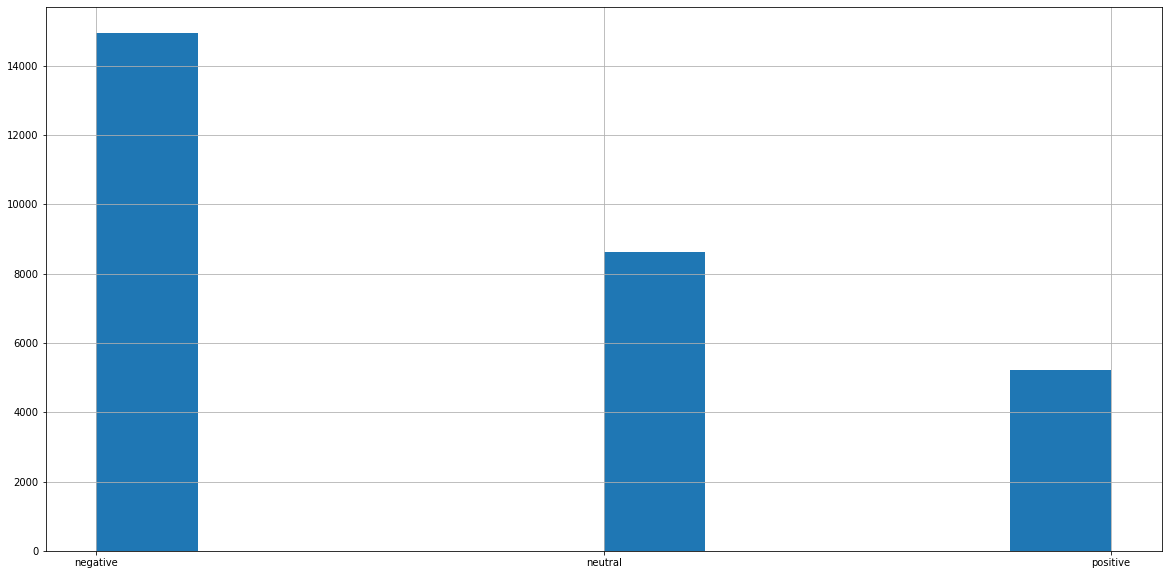

In [9]:
tweets_dataset["sentiment"].hist(figsize=(20, 10))

In [10]:
class SentimentAnalysisDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels):
        super().__init__()
        self.texts = texts
        self.labels = labels
        self.tweet_tokenizer = TweetTokenizer()
    
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        if "roberta" in config.model_name:
            tokenize_text = False
        else:
            text = self.tweet_tokenizer.tokenize(text)
            tokenize_text = True
        label = label2num[self.labels[idx]]
        tokenized_text = tokenizer(text, max_length=config.max_length, truncation=True, padding="max_length", is_split_into_words=tokenize_text)
        tokenized_text["label"] = torch.tensor(label)
        tokenized_text["input_ids"] = torch.tensor(tokenized_text["input_ids"])
        tokenized_text["attention_mask"] = torch.tensor(tokenized_text["attention_mask"])
        return tokenized_text

In [11]:
texts = tweets_dataset["content"].values
labels = tweets_dataset["sentiment"].values
train_texts, valid_texts = train_test_split(texts, shuffle=True, random_state=42, train_size=0.8)
train_labels, valid_labels = train_test_split(labels, shuffle=True, random_state=42, train_size=0.8)

In [12]:
train_dataset = SentimentAnalysisDataset(train_texts, train_labels)
train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, num_workers=2, batch_size=config.batch_size)
valid_dataset = SentimentAnalysisDataset(valid_texts, valid_labels)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, shuffle=True, num_workers=2, batch_size=config.batch_size)

In [13]:
classifier = AutoModelForSequenceClassification.from_pretrained(config.model_name).to(config.device)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(classifier.parameters(), lr=5e-6)

Downloading:   0%|          | 0.00/476M [00:00<?, ?B/s]

In [14]:
def ValidateModel():
    valid_accuracy = 0
    valid_loss = 0
    for example in valid_dataloader:
        input_ids = example["input_ids"].to(config.device)
        attn_masks = example["attention_mask"].to(config.device)
        labels = example["label"].to(config.device)
        with torch.no_grad():
            output = classifier(input_ids, attn_masks)
        loss = loss_fn(output[0].squeeze(), labels.squeeze())
        valid_accuracy +=  accuracy_score(labels.detach().cpu().numpy(), np.argmax(output[0].detach().cpu().numpy(), axis=1))
        valid_loss += loss.item()

    print(f"Validation Loss: {valid_loss/len(valid_dataloader)}")
    print(f"Validation Accuracy: {valid_accuracy/len(valid_dataloader)}")

In [15]:
batch_loss = 0
batch_accuracy = 0
for epoch in range(config.epochs):
    print("-"*15, ">", f"Epoch {epoch+1}", "<", "-"*15)
    print("\n")
    epoch_loss = 0
    epoch_accuracy = 0
    for batch_idx, (example) in enumerate(train_dataloader):
        optimizer.zero_grad()
        input_ids = example["input_ids"].to(config.device)
        attn_masks = example["attention_mask"].to(config.device)
        labels = example["label"].to(config.device)
        output = classifier(input_ids, attn_masks)[0]
        loss = loss_fn(output.squeeze(), labels.squeeze())

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_loss += loss.item()
        epoch_accuracy +=  accuracy_score(labels.detach().cpu().numpy(), np.argmax(output.detach().cpu().numpy(), axis=1))
        batch_accuracy += accuracy_score(labels.detach().cpu().numpy(), np.argmax(output.detach().cpu().numpy(), axis=1))
        
        if (batch_idx+1) % 25 == 0:
            print(f"Batch {batch_idx+1}/{len(train_dataloader)} | Categorical Cross Entropy Loss: {batch_loss/25}")
            batch_loss = 0
            print(f"Batch {batch_idx+1}/{len(train_dataloader)} | Accuracy Score: {batch_accuracy/25}")
            batch_accuracy = 0
        
    print(f"Epoch {epoch+1}/{config.epochs} | Categorical Cross Entropy Loss: {epoch_loss/len(train_dataloader)}")
    print(f"Epoch {epoch+1}/{config.epochs} | Accuracy Score: {epoch_accuracy/len(train_dataloader)}")
    torch.save(classifier.state_dict(), f"SentimentClassifierEpoch{epoch+1}.pth")
    print("\n")
    print("="*15, ">", f"VALIDATION", "<", "="*15)
    ValidateModel()
    print("\n")

--------------- > Epoch 1 < ---------------


Batch 25/1440 | Categorical Cross Entropy Loss: 0.7986007750034332
Batch 25/1440 | Accuracy Score: 0.705
Batch 50/1440 | Categorical Cross Entropy Loss: 0.7837968480587005
Batch 50/1440 | Accuracy Score: 0.705
Batch 75/1440 | Categorical Cross Entropy Loss: 0.8101060926914215
Batch 75/1440 | Accuracy Score: 0.635
Batch 100/1440 | Categorical Cross Entropy Loss: 0.7928782606124878
Batch 100/1440 | Accuracy Score: 0.65
Batch 125/1440 | Categorical Cross Entropy Loss: 0.7087374985218048
Batch 125/1440 | Accuracy Score: 0.69
Batch 150/1440 | Categorical Cross Entropy Loss: 0.7836839246749878
Batch 150/1440 | Accuracy Score: 0.68
Batch 175/1440 | Categorical Cross Entropy Loss: 0.7518324553966522
Batch 175/1440 | Accuracy Score: 0.68
Batch 200/1440 | Categorical Cross Entropy Loss: 0.7317327404022217
Batch 200/1440 | Accuracy Score: 0.65
Batch 225/1440 | Categorical Cross Entropy Loss: 0.7792169618606567
Batch 225/1440 | Accuracy Score: 0.64
Bat